# IPW v1: `Re78`

In [1]:
import sys

In [2]:
# append parent directory to use utils
sys.path.append("../")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from utils.bootstrap import bootstrap, bootstrap_experiment

from prop_utils import ipw, ipw_probs

In [4]:
lalonde_exp = pd.read_csv("../data/lalonde_exp.csv")
lalonde_obs = pd.read_csv("../data/lalonde_psid.csv")

In [5]:
lalonde_exp.shape, lalonde_obs.shape

((445, 13), (2675, 13))

Assume $Y$ represents our outcome variable, i.e., `re78`. Our set of confounders is $Z=$ {`education, re74, re75, black, hispanic, married`}. $A$ is our intervention variable which represents `treat` or job training. Recall our backdoor estimator for our average causal effect (risk difference):

\begin{align}
E[Y^a - Y^{a'}]
&= \sum_Z p(z) [E(Y \mid a, z) - E(Y \mid a', z)]\\
\end{align}

Our IPW formula looks like:

\begin{align}
E[Y^a]
&= \frac{1}{N} \sum_i Y_i \cdot \frac{1(A_i = a)}{p(A_i = a \mid Z)}\\
\end{align}

Where, $p(A \mid Z)$ is effectively probability of receiving treatment. This is also a higher variance estimator because it uses less data and also it divides by a high number.

## Experimental Data

In [6]:
ipw_result = ipw(
    lalonde_exp,
    "treat",
    "re78",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {ipw_result:.2f}."
)

The difference between the treatment and no-treatment groups is 1625.19.


In [7]:
ipw_results = bootstrap_experiment(
    df=lalonde_exp,
    function=ipw,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.80it/s]


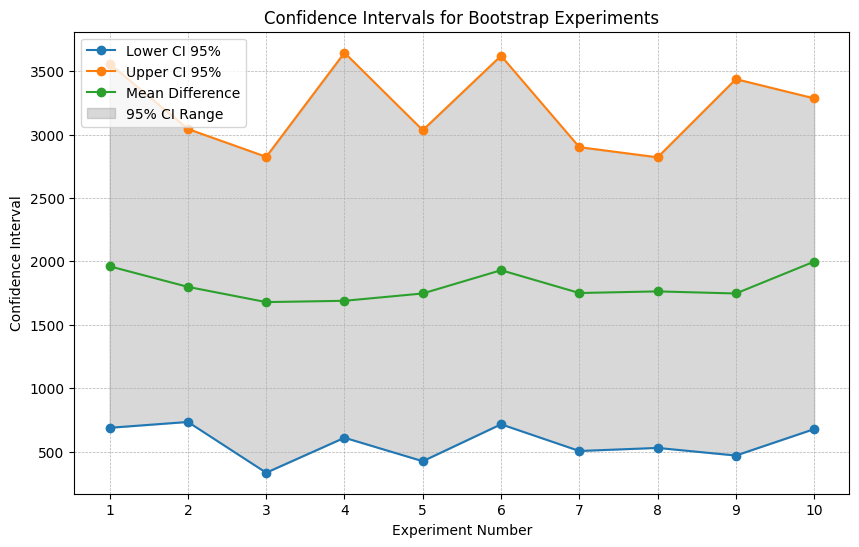

In [8]:
ci_df = pd.DataFrame(ipw_results, columns=["mean", "lower_ci", "upper_ci"])
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(10, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="Mean Difference", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Confidence Intervals for Bootstrap Experiments")
plt.legend()
plt.show()

## Observational Data

In [9]:
ipw_result = ipw(
    lalonde_obs,
    "treat",
    "re78",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)
print(
    f"The difference between the treatment and no-treatment groups is {ipw_result:.2f}."
)

The difference between the treatment and no-treatment groups is -11205.89.


In [10]:
ipw_results = bootstrap_experiment(
    df=lalonde_obs,
    function=ipw,
    num_exp=10,
    n=50,
    ci=95,
    treatment_col="treat",
    outcome_col="re78",
    confounder_cols=[
        "age",
        "education",
        "black",
        "hispanic",
        "married",
        "re74",
        "re75",
    ],
)

Running experiments: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.85s/it]


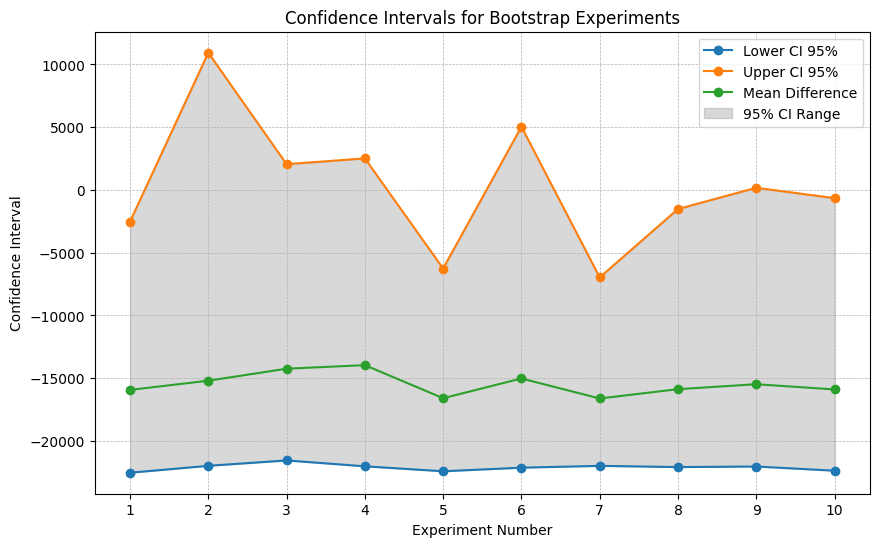

In [11]:
ci_df = pd.DataFrame(ipw_results, columns=["mean", "lower_ci", "upper_ci"])
ci_df["experiment"] = range(1, len(ci_df) + 1)

plt.figure(figsize=(10, 6))

plt.plot(ci_df["experiment"], ci_df["lower_ci"], label="Lower CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["upper_ci"], label="Upper CI 95%", marker="o")
plt.plot(ci_df["experiment"], ci_df["mean"], label="Mean Difference", marker="o")

plt.fill_between(
    ci_df["experiment"],
    ci_df["lower_ci"],
    ci_df["upper_ci"],
    color="gray",
    alpha=0.3,
    label="95% CI Range",
)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(ci_df["experiment"])
plt.xlabel("Experiment Number")
plt.ylabel("Confidence Interval")
plt.title("Confidence Intervals for Bootstrap Experiments")
plt.legend()
plt.show()

In [12]:
ipw_prob_results_df = ipw_probs(
    lalonde_obs,
    "treat",
    "re78",
    ["age", "education", "black", "hispanic", "married", "re74", "re75"],
)

In [13]:
lalonde_obs_ipw_df = pd.merge(lalonde_obs, ipw_prob_results_df, on=["id"])

In [14]:
lalonde_obs_ipw_df.groupby(["black", "hispanic", "married", "nodegree", "treat"]).agg(
    n=("ipw", "count"),
    ipw_mean=("ipw", "mean"),
    ipw_median=("ipw", "median"),
    ipw_percentile_25=("ipw", lambda x: np.percentile(x, 25)),
    ipw_percentile_75=("ipw", lambda x: np.percentile(x, 75)),
    re78_mean=("re78", "mean"),
    re78_median=("re78", "median"),
    re78_percentile_25=("re78", lambda x: np.percentile(x, 25)),
    re78_percentile_75=("re78", lambda x: np.percentile(x, 75)),
    re75_mean=("re75", "mean"),
    re75_median=("re75", "median"),
    re75_percentile_25=("re75", lambda x: np.percentile(x, 25)),
    re75_percentile_75=("re75", lambda x: np.percentile(x, 75)),
).reset_index().sort_values(["black", "hispanic", "married", "nodegree", "treat"])

,black,hispanic,married,nodegree,treat,n,ipw_mean,ipw_median,ipw_percentile_25,ipw_percentile_75,re78_mean,re78_median,re78_percentile_25,re78_percentile_75,re75_mean,re75_median,re75_percentile_25,re75_percentile_75
0,0,0,0,0,0,167,1.044615,1.001258,1.000023,1.016054,20476.281914,20132.546875,9605.222656,29569.308594,17215.463243,17008.064453,7161.290527,25601.613281
1,0,0,0,0,1,7,8.076373,6.155729,2.899475,7.564608,7337.242857,5587.500000,5045.675000,10303.300000,1628.681286,0.000000,0.000000,1472.634500
2,0,0,0,1,0,28,1.058451,1.019325,1.000597,1.075055,15104.001639,13225.652832,6169.508545,19265.859863,12466.399850,10294.354492,4565.322754,15665.322998
3,0,0,0,1,1,8,3.203601,2.691653,2.214345,4.261465,8870.848750,9798.875000,3503.390000,13496.825000,1058.742250,0.000000,0.000000,1246.236000
4,0,0,1,0,0,1225,1.003740,1.000017,1.000000,1.000408,25745.981257,25195.238281,16993.855469,33426.175781,23035.823532,21546.531250,14322.581055,30435.484375
5,0,0,1,0,1,2,29.208087,29.208087,23.395067,35.021106,6209.050000,6209.050000,3104.525000,9313.575000,426.861500,426.861500,213.430750,640.292250
6,0,0,1,1,0,365,1.005605,1.000081,1.000008,1.001562,18292.392600,17732.718750,8866.359375,25860.214844,16520.704468,16148.709961,8844.193359,22916.128906
7,0,0,1,1,1,1,9.668568,9.668568,9.668568,9.668568,4232.310000,4232.310000,4232.310000,4232.310000,1713.150000,1713.150000,1713.150000,1713.150000
8,0,1,0,0,0,3,3.642755,3.233452,2.117420,4.963439,13090.194417,8275.268555,5966.320923,17806.604980,7781.935420,71.612900,35.806450,11672.903130
9,0,1,0,0,1,1,1.720290,1.720290,1.720290,1.720290,559.443000,559.443000,559.443000,559.443000,1117.440000,1117.440000,1117.440000,1117.440000
